# Лабораторная работа №1: Первичное исследование и оценка качества данных
**Дисциплина:** Интеллектуальный анализ данных  
**Датасет:** UCI Bike Sharing Dataset (hour.csv)  
**Цель:** первично описать структуру данных, оценить качество (пропуски/дубликаты/аномалии) и выполнить мини‑EDA. 

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

PATH = "../data/raw/hour.csv"

df = pd.read_csv(PATH)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## 1. Постановка задачи (Business Understanding)

**Что это за данные.**  
Датасет содержит почасовые наблюдения по прокату велосипедов в городской системе bike-sharing.  
Каждая строка соответствует одному часу и содержит суммарное число аренд, а также погодные и календарные факторы (сезон, месяц, день недели, рабочий/выходной и т.д.).  
Данные позволяют изучить, как условия среды и календарь влияют на спрос на аренду велосипедов.  
Также по данным можно выявлять нестандартные/аномальные периоды, когда спрос резко отличается от ожидаемого.

**Кто может быть условным «заказчиком» анализа.**  
Оператор системы проката (компания/муниципальная организация), городские службы планирования транспорта или продуктовая команда сервиса, отвечающая за планирование количества велосипедов.

**Возможные задачи интеллектуального анализа данных.**  
1) **Прогнозирование спроса** (регрессия): предсказать `cnt` (общее число аренд в час) по погоде и календарю для планирования ресурсов.  
2) **Поиск аномалий**: обнаружить часы/дни с нетипично низким или высоким спросом (возможные сбои учёта, ошибки данных).  

## 2. Паспорт датасета (Data Understanding)

В этом разделе загружаем данные, фиксируем размер, список признаков и их типы, а также при необходимости приводим типы к более подходящим (дата, категориальные коды).

In [5]:
n_rows, n_cols = df.shape
print("Количество строк:", n_rows)
print("Количество столбцов:", n_cols)

Количество строк: 17379
Количество столбцов: 17


In [6]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  str    
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), str(1)
memory usage: 2.3 MB


In [7]:
schema = pd.DataFrame({
    "column": df.columns,
    "dtype_pandas": [df[c].dtype for c in df.columns],
    "non_null": [df[c].notna().sum() for c in df.columns],
    "missing": [df[c].isna().sum() for c in df.columns],
    "n_unique": [df[c].nunique(dropna=True) for c in df.columns],
})
schema

,column,dtype_pandas,non_null,missing,n_unique
0,instant,int64,17379,0,17379
1,dteday,str,17379,0,731
2,season,int64,17379,0,4
3,yr,int64,17379,0,2
4,mnth,int64,17379,0,12
5,hr,int64,17379,0,24
6,holiday,int64,17379,0,2
7,weekday,int64,17379,0,7
8,workingday,int64,17379,0,2
9,weathersit,int64,17379,0,4


### 2.4 Приведение типов признаков

В исходном CSV некоторые признаки представлены целыми кодами, но по смыслу являются категориальными (например, `season`, `weathersit`, `weekday`, `workingday`).  
Также `dteday` нужно привести к типу даты. Для удобства анализа добавим столбец `datetime` (дата + час).

In [9]:
# дата
df["dteday"] = pd.to_datetime(df["dteday"], errors="coerce")

# категориальные коды 
cat_cols = ["season","yr","mnth","hr","holiday","weekday","workingday","weathersit"]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

# единый datetime 
df["datetime"] = df["dteday"] + pd.to_timedelta(df["hr"].astype(int), unit="h")

df.dtypes

instant                int64
dteday        datetime64[us]
season              category
yr                  category
mnth                category
hr                  category
holiday             category
weekday             category
workingday          category
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
datetime      datetime64[us]
dtype: object

### 2.5 Предположительный смысл признаков (по названиям/описанию датасета)

- `datetime` - временная метка наблюдения (дата + час).  
- `dteday` - дата наблюдения.  
- `hr` - час (0-23).  
- `season` - сезон (код).  
- `yr` - год (код, обычно 0/1).  
- `mnth` - месяц (1-12).  
- `weekday` - день недели (0-6).  
- `workingday` - индикатор рабочего дня (0/1).  
- `holiday` - индикатор праздника (0/1).  
- `weathersit` - тип погодной ситуации (код).  
- `temp`, `atemp`, `hum`, `windspeed` - погодные показатели (часто нормированы).  
- `casual` - число аренд незарегистрированными пользователями.  
- `registered` - число аренд зарегистрированными пользователями.  
- `cnt` - общее число аренд за час (`casual + registered`).

## 3. Аудит качества данных

Проверяем пропуски, дубликаты, типичные проблемы значений и выбросы.  
Цель - выявить потенциальные проблемы, которые могут исказить выводы или ухудшить качество моделей.

In [10]:
missing = (df.isna().sum()
           .to_frame("missing_count")
           .assign(missing_pct=lambda x: 100*x["missing_count"]/len(df))
           .sort_values("missing_count", ascending=False))
missing

,missing_count,missing_pct
instant,0,0.0
dteday,0,0.0
season,0,0.0
yr,0,0.0
mnth,0,0.0
hr,0,0.0
holiday,0,0.0
weekday,0,0.0
workingday,0,0.0
weathersit,0,0.0


  ### 3.1 Вывод по пропускам

По результатам расчёта пропусков во всех столбцах датасета пропущенные значения **не обнаружены** (0 значений, 0%).  
Это упрощает дальнейший анализ: не требуется удаление строк или импутация значений.  
Однако отсутствие `NaN` не гарантирует идеальное качество: возможны некорректные коды категорий, ошибки диапазонов и выбросы, поэтому остальные проверки остаются актуальными.

### 3.2 Вывод по дубликатам

Полностью дублирующихся строк не найдено: **0**.  
Также не найдено дубликатов по логическому ключу **(dteday, hr)**: **0**.  
Это означает, что на уровне структуры наблюдений (одна запись на один час) явных нарушений уникальности нет.

In [11]:
full_dups = df.duplicated().sum()
key_dups = df.duplicated(subset=["dteday","hr"]).sum()

print("Полных дубликатов строк:", full_dups)
print("Дубликатов по ключу (dteday, hr):", key_dups)

Полных дубликатов строк: 0
Дубликатов по ключу (dteday, hr): 0


### 3.3 Вывод по типическим проблемам значений

Проверка консистентности ключевых счётчиков показала, что во всех строках выполняется равенство  
**cnt = casual + registered** (нарушений: **0**).  

In [12]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000
atemp,17379.0,0.475775,0.171850,0.00,0.3333,0.4848,0.6212,1.0000
hum,17379.0,0.627229,0.192930,0.00,0.4800,0.6300,0.7800,1.0000
windspeed,17379.0,0.190098,0.122340,0.00,0.1045,0.1940,0.2537,0.8507
casual,17379.0,35.676218,49.305030,0.00,4.0000,17.0000,48.0000,367.0000
registered,17379.0,153.786869,151.357286,0.00,34.0000,115.0000,220.0000,886.0000
cnt,17379.0,189.463088,181.387599,1.00,40.0000,142.0000,281.0000,977.0000


In [13]:
# 1) счетчики не должны быть отрицательными
for c in ["casual","registered","cnt"]:
    if c in df.columns:
        print(c, "negative:", int((df[c] < 0).sum()))

# 2) диапазоны кодов для времени/календаря
def out_of_range_count(series, low, high):
    s = series.astype("int64", errors="ignore")
    return int((~s.between(low, high)).sum())

print("hr out of 0..23:", out_of_range_count(df["hr"], 0, 23))
print("weekday out of 0..6:", out_of_range_count(df["weekday"], 0, 6))
print("mnth out of 1..12:", out_of_range_count(df["mnth"], 1, 12))

# 3) консистентность: cnt = casual + registered
if set(["casual","registered","cnt"]).issubset(df.columns):
    inconsistent = df[df["cnt"] != df["casual"] + df["registered"]]
    print("Строк с нарушением cnt = casual + registered:", len(inconsistent))
    display(inconsistent[["dteday","hr","casual","registered","cnt"]].head())

casual negative: 0
registered negative: 0
cnt negative: 0
hr out of 0..23: 0
weekday out of 0..6: 0
mnth out of 1..12: 0
Строк с нарушением cnt = casual + registered: 0


,dteday,hr,casual,registered,cnt


### 3.4 Вывод по выбросам (IQR)

Для признака `cnt` был применён метод межквартильного размаха (IQR).  
Границы “нормального” диапазона по IQR составили **[-321.5; 642.5]**, при этом наблюдений, попавших в зону выбросов, — **505**.

Нижняя граница получилась отрицательной, а `cnt` по смыслу не может быть меньше 0, поэтому практически значимыми являются в основном **верхние выбросы** (`cnt > 642.5`).  
Такие высокие значения могут быть как реальными пиками спроса (сезон/погода/мероприятия), так и поводом проверить контекст и корректность измерений.

In [14]:
x = df["cnt"].dropna()

q1, q3 = x.quantile([0.25, 0.75])
iqr = q3 - q1
low, high = q1 - 1.5*iqr, q3 + 1.5*iqr

outliers = df[(df["cnt"] < low) | (df["cnt"] > high)]

print("IQR boundaries:", (low, high))
print("Outliers count:", len(outliers))
outliers[["datetime","cnt","casual","registered","weathersit","workingday"]].head(10)

IQR boundaries: (-321.5, 642.5)
Outliers count: 505


,datetime,cnt,casual,registered,weathersit,workingday
5536,2011-08-23 14:00:00,651,149,502,1,1
10358,2012-03-12 17:00:00,644,87,557,2,1
10359,2012-03-12 18:00:00,712,89,623,2,1
10382,2012-03-13 17:00:00,676,62,614,1,1
10383,2012-03-13 18:00:00,734,96,638,1,1
10397,2012-03-14 08:00:00,662,34,628,1,1
10406,2012-03-14 17:00:00,782,140,642,1,1
10407,2012-03-14 18:00:00,749,102,647,1,1
10430,2012-03-15 17:00:00,713,79,634,1,1
10431,2012-03-15 18:00:00,746,98,648,1,1


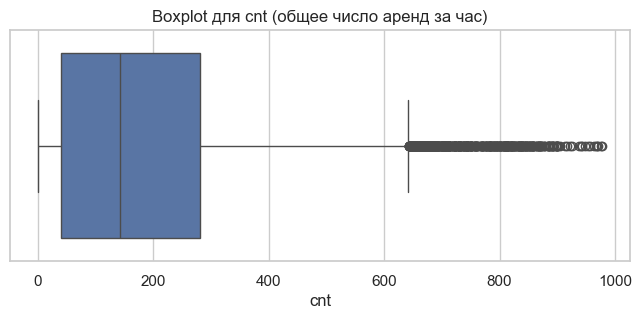

In [15]:
plt.figure(figsize=(8, 3))
sns.boxplot(x=df["cnt"])
plt.title("Boxplot для cnt (общее число аренд за час)")
plt.xlabel("cnt")
plt.show()

## 4. Разведочный анализ (Mini‑EDA)

Строим:
1) распределение ключевого числового признака (`cnt`);  
2) распределение категориального признака (например, `weathersit`);  
3) зависимость между двумя признаками (например, средний спрос по часам в рабочие/выходные).

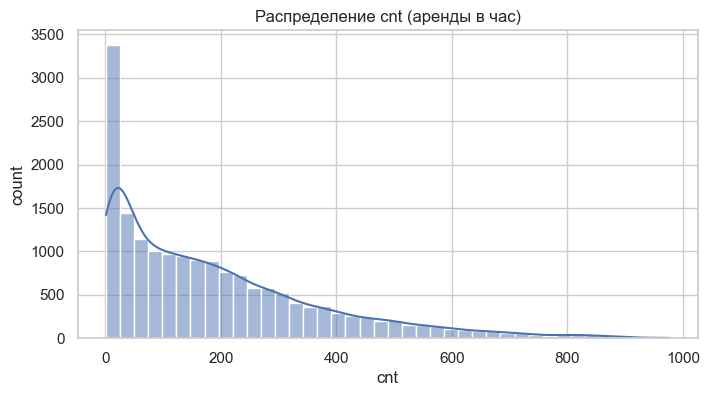

In [16]:
plt.figure(figsize=(8, 4))
sns.histplot(df["cnt"], bins=40, kde=True)
plt.title("Распределение cnt (аренды в час)")
plt.xlabel("cnt")
plt.ylabel("count")
plt.show()

По распределению видно, что спрос распределён неравномерно и имеет “хвост” высоких значений.  
Это может означать наличие пиковых периодов.  

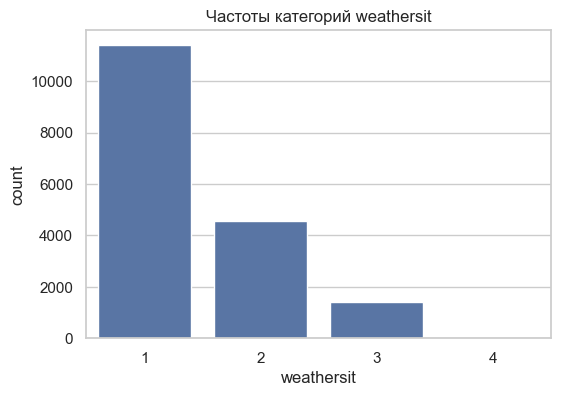

In [17]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="weathersit")
plt.title("Частоты категорий weathersit")
plt.xlabel("weathersit")
plt.ylabel("count")
plt.show()

Частоты по `weathersit` показывают, какие типы погоды встречаются чаще всего.  
Если некоторые категории редкие, то при моделировании это может приводить к нестабильным оценкам или потребовать объединения редких классов.

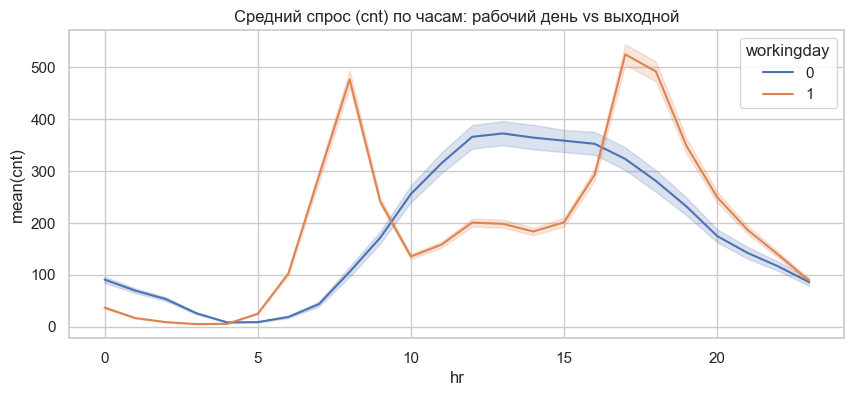

In [18]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x="hr", y="cnt", hue="workingday", estimator="mean")
plt.title("Средний спрос (cnt) по часам: рабочий день vs выходной")
plt.xlabel("hr")
plt.ylabel("mean(cnt)")
plt.show()

График показывает суточный профиль спроса и различия между рабочими днями и выходными.  
Обычно в рабочие дни можно ожидать пики в часы поездок на работу/с работы, а в выходные - более “плоский” профиль. 